In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import torch
import torch.nn as nn
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/pytorch")
from pinns import *
from local_utils import *

from pinns import *
from intro import *

In [2]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
dev_str = f"{device.type}:{device.index}"

In [3]:
import pickle
with open(f"./inputs/solution_31.pkl", "rb") as f:
    (run_params, params, solution) = pickle.load(f)
    
    
run_params = Struct(**run_params)
params = Struct(**params)

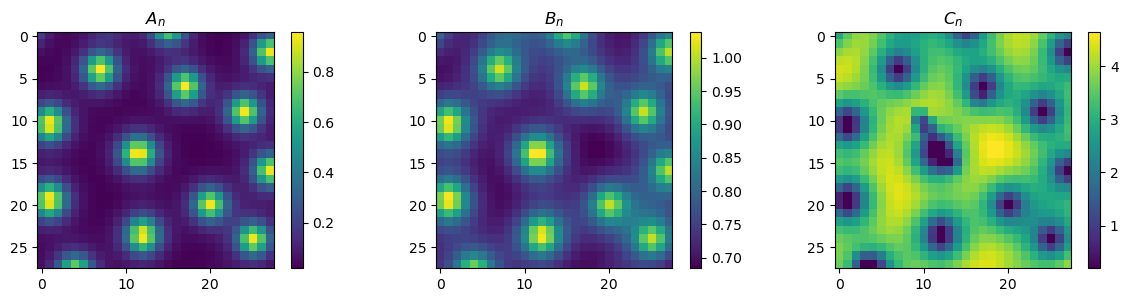

In [4]:
A_n = solution[-1, 0, :, :]
B_n = solution[-1, 1, :, :]
C_n = solution[-1, 2, :, :]

#############################################################
#    Inner boundaries
# By using these slices, we can remove the boundary effects
# or select a smaller portion of the domain
#
#   Important: slices must not be larger than slices(1,-1,1).
#              Otherwise, the boundary effects of finit difference
#              Laplacian cannot be removed
#
x_slice = slice(50,-50, 1)
y_slice = slice(50,-50, 1)

to = create_to(A_n[x_slice,y_slice])
########################################
# Take the average of data points
kernel =np.array([[1, 1],
                  [1, 1]])


A_n = ndimage.convolve(A_n, kernel)/4
B_n = ndimage.convolve(B_n, kernel)/4
C_n = ndimage.convolve(C_n, kernel)/4
############################################################
plot_n_im([A_n[x_slice,y_slice], 
           B_n[x_slice,y_slice], 
           C_n[x_slice,y_slice]], 
          [r"$A_{n}$", r"$B_{n}$", r"$C_{n}$"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

In [28]:
Ks_bounds

{'K_AA': (0.003017188882164607, 3.717165551194257),
 'K_AB': (0.003017188882164607, 3.717165551194257),
 'K_AC': (0.003017188882164607, 3.717165551194257),
 'K_BA': (0.17375177003837622, 3.9346965764193462),
 'K_BC': (0.17375177003837622, 3.9346965764193462),
 'K_CB': (0.05347716742023338, 19.978550398601133),
 'K_CC': (0.05347716742023338, 19.978550398601133)}

In [5]:
A_min, A_max = np.min(A_n), np.max(A_n)
B_min, B_max = np.min(B_n), np.max(B_n)
C_min, C_max = np.min(C_n), np.max(C_n)
n = params["n"]
tol = .005

def define_bound(tol, n, x_min, x_max):
    upper = ((1-tol)/tol)**(1/n)
    lower = (tol/(1-tol))**(1/n)
    # return (lower, upper) bounds and the initial guess
    #return (max(0,x_min*lower), x_max*upper), max(0, (x_max*upper-max(0,x_min*lower))/2)
    return (max(0,x_min*lower), x_max*upper), max(0, (x_max*upper-max(0,x_min*lower))/2)
    
K_AA_bound, K_AA_init =  define_bound(tol, n, A_min, A_max)
K_AB_bound, K_AB_init =  define_bound(tol, n, A_min, A_max)
K_AC_bound, K_AC_init =  define_bound(tol, n, A_min, A_max)
K_BA_bound, K_BA_init =  define_bound(tol, n, B_min, B_max)
K_BC_bound, K_BC_init =  define_bound(tol, n, B_min, B_max)
K_CB_bound, K_CB_init =  define_bound(tol, n, C_min, C_max)
K_CC_bound, K_CC_init =  define_bound(tol, n, C_min, C_max)

Ks_bounds = {"K_AA":K_AA_bound, 
             "K_AB":K_AB_bound, 
             "K_AC":K_AC_bound,
             "K_BA":K_BA_bound, 
             "K_BC":K_BC_bound,
             "K_CB":K_CB_bound, 
             "K_CC": K_CC_bound}
def closest_bound(name, v):
    if not name.startswith("K"):
        return np.nan
    lower, upper = Ks_bounds[name]
    if np.abs(v-lower) < np.abs(v-upper):
        return lower
    else:
        return upper 
def get_bound(name):
    if not name.startswith("K"):
        return (0, None)
    return Ks_bounds[name]


Epoch: 1 
 data loss:4.223175, 
data A loss:0.308683, data B loss:0.779100, data C loss:3.135393, 
Laplacian A loss:28.469225, Laplacian B loss:7.969543
Physics loss:1.729139
Negative loss:0.039914

 b_A=0.9000, b_B=0.9000, b_C=0.9000, V_A=0.9996, V_B=0.9996, V_C=1.0000, mu_A=0.9002, mu_B=1.0996, K_AA=1.8580, K_AB=1.8579, K_AC=1.8571, K_BA=1.8805, K_BC=1.8805, K_CB=9.9625, K_CC=9.9625


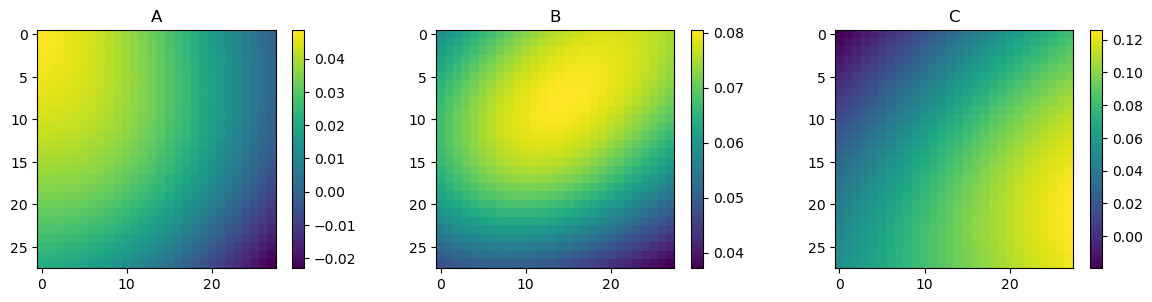

Epoch: 10000 
 data loss:0.171430, 
data A loss:0.068464, data B loss:0.032781, data C loss:0.070185, 
Laplacian A loss:0.379497, Laplacian B loss:0.237014
Physics loss:1.643711
Negative loss:0.001987

 b_A=-0.1052, b_B=-0.0072, b_C=0.4860, V_A=2.6580, V_B=54.9118, V_C=1.8419, mu_A=0.7198, mu_B=3.3918, K_AA=0.7108, K_AB=0.7220, K_AC=3.7188, K_BA=3.9392, K_BC=2.6655, K_CB=2.6521, K_CC=2.7726


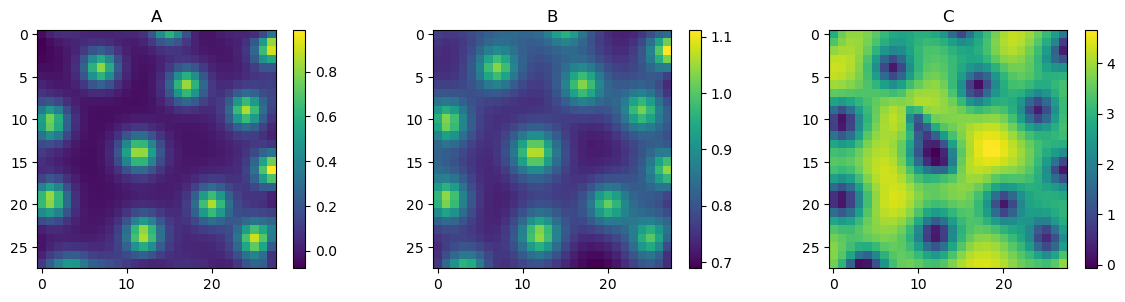

Epoch: 20000 
 data loss:0.088675, 
data A loss:0.028822, data B loss:0.011483, data C loss:0.048370, 
Laplacian A loss:0.157470, Laplacian B loss:0.135613
Physics loss:0.987501
Negative loss:0.000314

 b_A=-0.0703, b_B=-0.0022, b_C=0.4774, V_A=2.7372, V_B=58.8256, V_C=1.8656, mu_A=0.7806, mu_B=3.5383, K_AA=0.6867, K_AB=0.7246, K_AC=3.7189, K_BA=3.9374, K_BC=1.8179, K_CB=4.0690, K_CC=2.7317


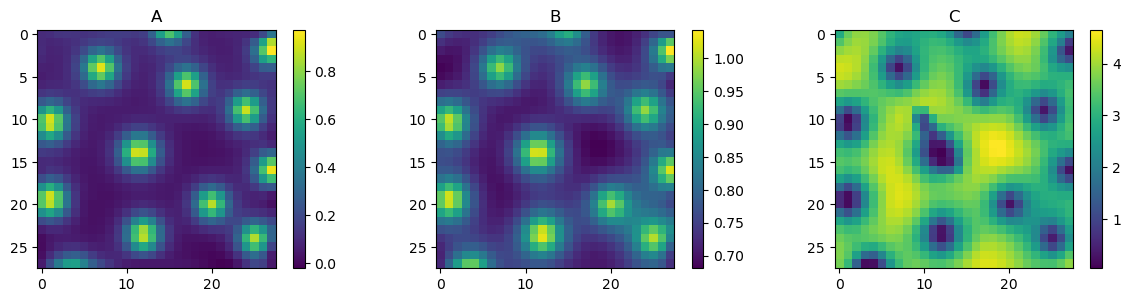

Epoch: 30000 
 data loss:0.063045, 
data A loss:0.021725, data B loss:0.009018, data C loss:0.032302, 
Laplacian A loss:0.093999, Laplacian B loss:0.095181
Physics loss:0.762090
Negative loss:0.000000

 b_A=-0.0791, b_B=0.0001, b_C=0.4713, V_A=2.7574, V_B=60.9702, V_C=1.9913, mu_A=0.7889, mu_B=3.5905, K_AA=0.6859, K_AB=0.7368, K_AC=3.7189, K_BA=3.9353, K_BC=1.2146, K_CB=7.1468, K_CC=2.6045


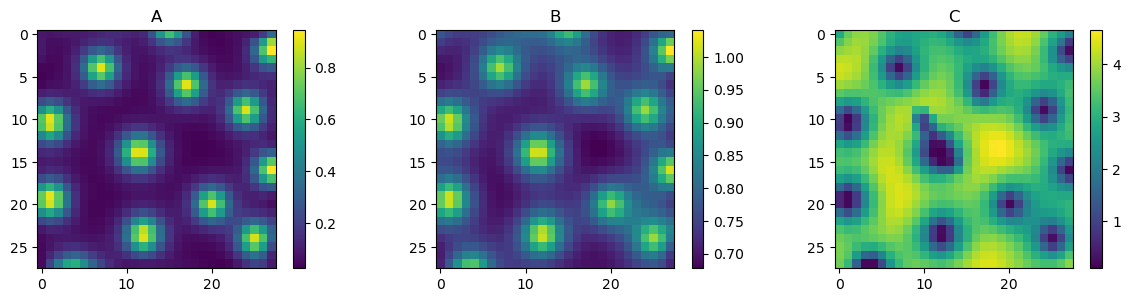

Epoch: 40000 
 data loss:0.053277, 
data A loss:0.020076, data B loss:0.008603, data C loss:0.024599, 
Laplacian A loss:0.084803, Laplacian B loss:0.070056
Physics loss:0.763968
Negative loss:0.000257

 b_A=-0.0791, b_B=0.0017, b_C=0.4214, V_A=2.7652, V_B=61.7115, V_C=2.7367, mu_A=0.7968, mu_B=3.6073, K_AA=0.6852, K_AB=0.7414, K_AC=3.7190, K_BA=3.9347, K_BC=0.8098, K_CB=19.5419, K_CC=2.1788


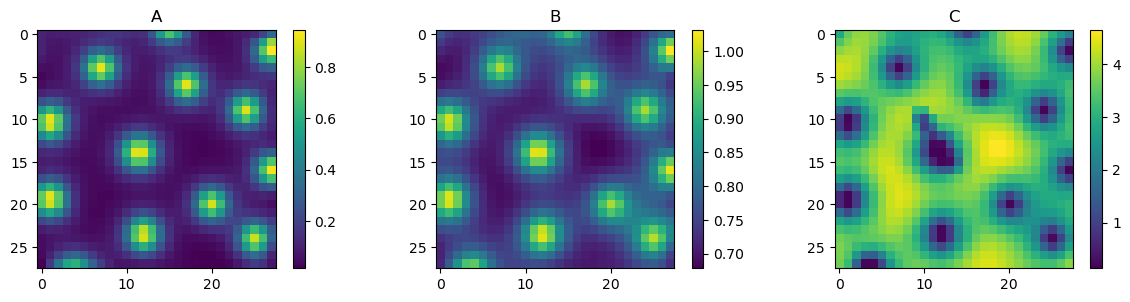

Epoch: 50000 
 data loss:0.041241, 
data A loss:0.014800, data B loss:0.007693, data C loss:0.018748, 
Laplacian A loss:0.137206, Laplacian B loss:0.055359
Physics loss:0.559315
Negative loss:0.000000

 b_A=-0.0861, b_B=-0.0042, b_C=0.4002, V_A=2.7688, V_B=62.1165, V_C=3.3102, mu_A=0.8007, mu_B=3.6127, K_AA=0.6868, K_AB=0.7437, K_AC=3.7190, K_BA=3.8509, K_BC=0.7193, K_CB=19.9846, K_CC=2.0236


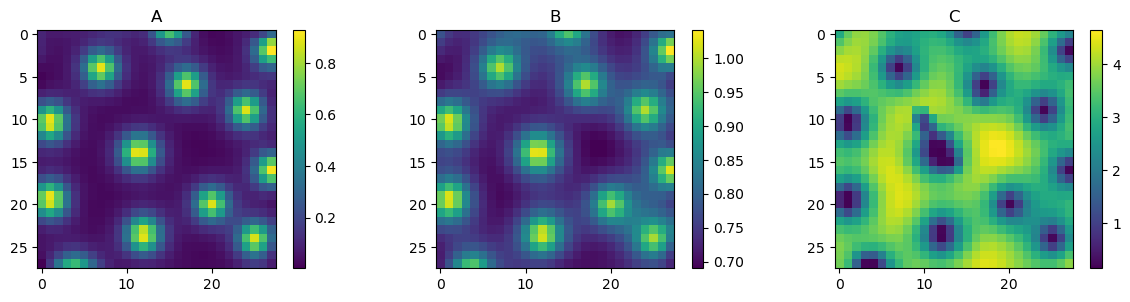

Epoch: 60000 
 data loss:0.052402, 
data A loss:0.016650, data B loss:0.006930, data C loss:0.028822, 
Laplacian A loss:0.137407, Laplacian B loss:0.041203
Physics loss:0.629973
Negative loss:0.000000

 b_A=-0.0897, b_B=-0.0046, b_C=0.3604, V_A=2.8527, V_B=62.3764, V_C=3.7760, mu_A=0.7927, mu_B=3.6028, K_AA=0.6948, K_AB=0.7493, K_AC=3.7191, K_BA=2.3964, K_BC=0.6767, K_CB=19.9857, K_CC=1.8838


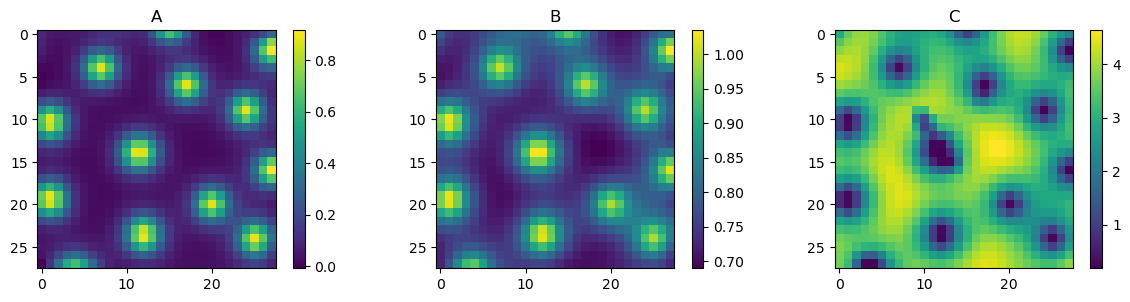

Epoch: 70000 
 data loss:0.050967, 
data A loss:0.018242, data B loss:0.009672, data C loss:0.023053, 
Laplacian A loss:0.065878, Laplacian B loss:0.052409
Physics loss:0.761275
Negative loss:0.000000

 b_A=-0.1254, b_B=-0.0224, b_C=0.3973, V_A=3.4408, V_B=62.5214, V_C=3.9770, mu_A=0.7278, mu_B=3.5518, K_AA=0.7407, K_AB=0.7557, K_AC=3.7187, K_BA=1.5494, K_BC=0.6554, K_CB=19.9802, K_CC=1.9454


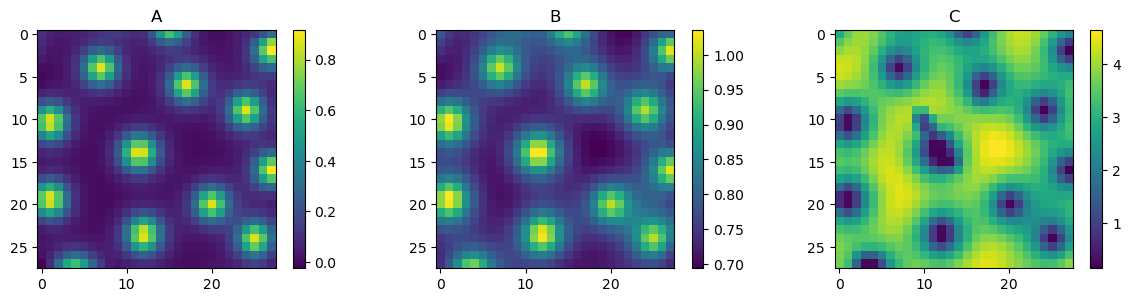

Epoch: 80000 
 data loss:0.047412, 
data A loss:0.014938, data B loss:0.006702, data C loss:0.025773, 
Laplacian A loss:0.119722, Laplacian B loss:0.061138
Physics loss:0.603044
Negative loss:0.000000

 b_A=-0.0865, b_B=-0.0038, b_C=0.3403, V_A=4.3215, V_B=62.6748, V_C=4.3413, mu_A=0.7889, mu_B=3.6058, K_AA=0.7376, K_AB=0.7517, K_AC=3.7191, K_BA=1.2144, K_BC=0.6387, K_CB=19.9862, K_CC=1.7857


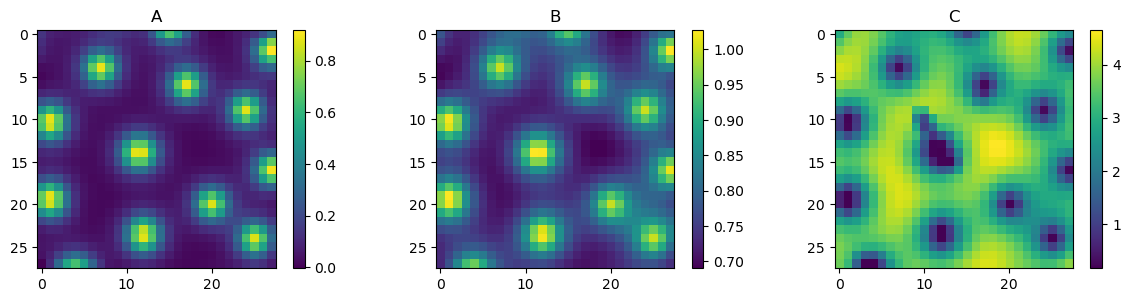

Epoch: 90000 
 data loss:0.042799, 
data A loss:0.021783, data B loss:0.010193, data C loss:0.010823, 
Laplacian A loss:0.069267, Laplacian B loss:0.043114
Physics loss:0.891189
Negative loss:0.001293

 b_A=-0.0816, b_B=0.0077, b_C=0.3491, V_A=5.4008, V_B=62.7894, V_C=4.5795, mu_A=0.7541, mu_B=3.5785, K_AA=0.7595, K_AB=0.7464, K_AC=3.7190, K_BA=1.0858, K_BC=0.6330, K_CB=19.9847, K_CC=1.7542


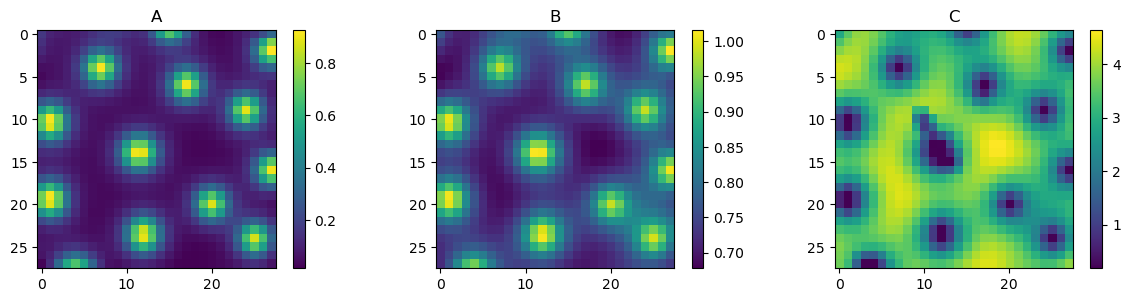

Epoch: 100000 
 data loss:0.024747, 
data A loss:0.012046, data B loss:0.003871, data C loss:0.008830, 
Laplacian A loss:0.035077, Laplacian B loss:0.015984
Physics loss:0.497759
Negative loss:0.000000

 b_A=-0.0760, b_B=-0.0035, b_C=0.3430, V_A=6.5623, V_B=62.8545, V_C=4.6971, mu_A=0.7951, mu_B=3.6025, K_AA=0.7682, K_AB=0.7501, K_AC=3.7190, K_BA=0.9848, K_BC=0.6218, K_CB=19.9869, K_CC=1.7531


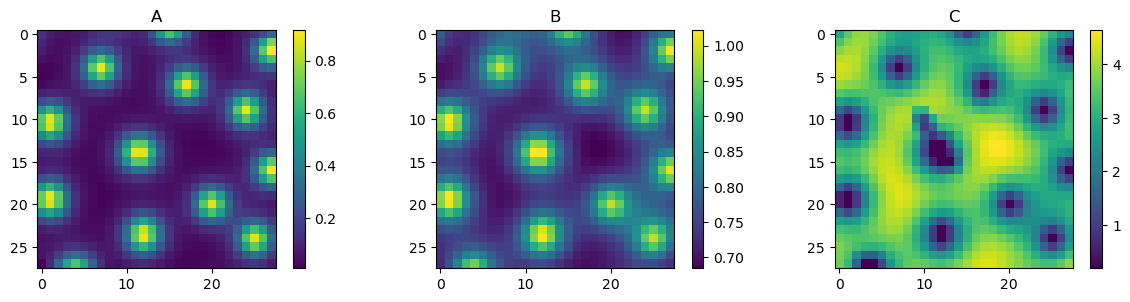

Epoch: 110000 
 data loss:0.025907, 
data A loss:0.012021, data B loss:0.005835, data C loss:0.008051, 
Laplacian A loss:0.052141, Laplacian B loss:0.036669
Physics loss:0.512315
Negative loss:0.000000

 b_A=-0.0935, b_B=-0.0071, b_C=0.3685, V_A=7.9629, V_B=62.9278, V_C=4.8606, mu_A=0.7183, mu_B=3.5743, K_AA=0.8087, K_AB=0.7505, K_AC=3.7188, K_BA=0.9295, K_BC=0.6107, K_CB=19.9841, K_CC=1.7747


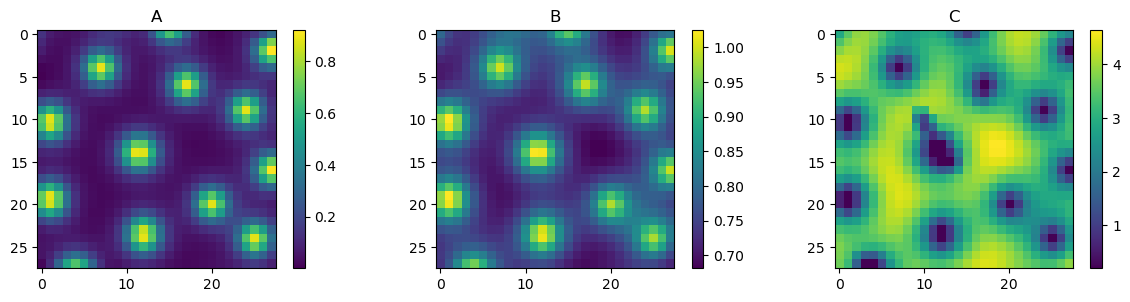

Epoch: 120000 
 data loss:0.031869, 
data A loss:0.012328, data B loss:0.006010, data C loss:0.013530, 
Laplacian A loss:0.047984, Laplacian B loss:0.032831
Physics loss:0.494951
Negative loss:0.000000

 b_A=-0.0827, b_B=-0.0055, b_C=0.3381, V_A=9.4578, V_B=63.0121, V_C=4.9874, mu_A=0.7839, mu_B=3.6038, K_AA=0.8015, K_AB=0.7514, K_AC=3.7190, K_BA=0.8637, K_BC=0.6059, K_CB=19.9869, K_CC=1.7267


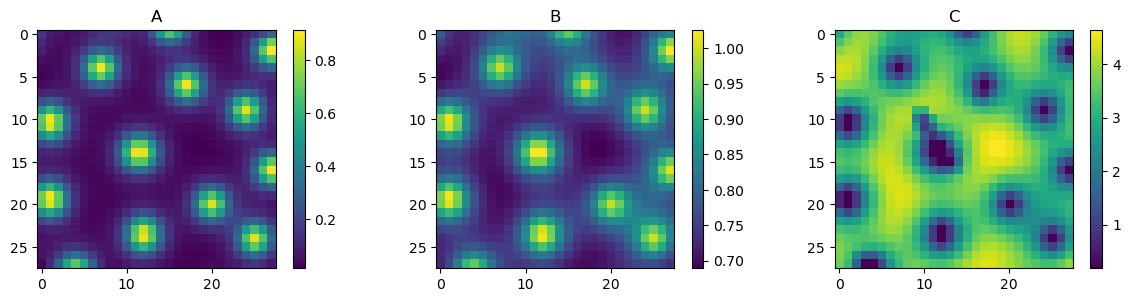

Epoch: 130000 
 data loss:0.023344, 
data A loss:0.011721, data B loss:0.003761, data C loss:0.007862, 
Laplacian A loss:0.044395, Laplacian B loss:0.019661
Physics loss:0.488388
Negative loss:0.000000

 b_A=-0.0763, b_B=-0.0041, b_C=0.3267, V_A=10.9741, V_B=63.0727, V_C=5.0945, mu_A=0.7916, mu_B=3.6069, K_AA=0.8078, K_AB=0.7516, K_AC=3.7191, K_BA=0.8230, K_BC=0.6038, K_CB=19.9870, K_CC=1.6954


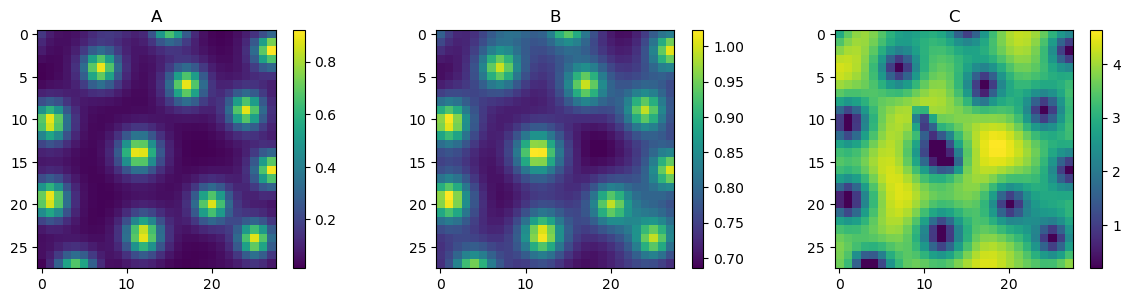

Epoch: 140000 
 data loss:0.021883, 
data A loss:0.011401, data B loss:0.003644, data C loss:0.006838, 
Laplacian A loss:0.024519, Laplacian B loss:0.019407
Physics loss:0.462335
Negative loss:0.000000

 b_A=-0.0746, b_B=-0.0036, b_C=0.3241, V_A=12.3720, V_B=63.1169, V_C=5.0911, mu_A=0.7962, mu_B=3.6077, K_AA=0.8137, K_AB=0.7516, K_AC=3.7191, K_BA=0.7933, K_BC=0.6045, K_CB=19.9869, K_CC=1.6911


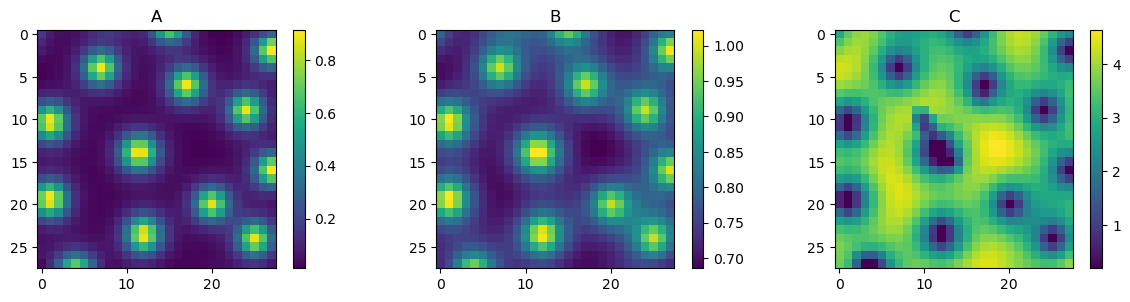

Epoch: 150000 
 data loss:0.039648, 
data A loss:0.011497, data B loss:0.005076, data C loss:0.023075, 
Laplacian A loss:0.035179, Laplacian B loss:0.029809
Physics loss:0.483505
Negative loss:0.000000

 b_A=-0.0695, b_B=-0.0011, b_C=0.3281, V_A=13.8270, V_B=63.1890, V_C=5.1828, mu_A=0.7950, mu_B=3.6064, K_AA=0.8179, K_AB=0.7512, K_AC=3.7192, K_BA=0.7689, K_BC=0.6040, K_CB=19.9871, K_CC=1.6848


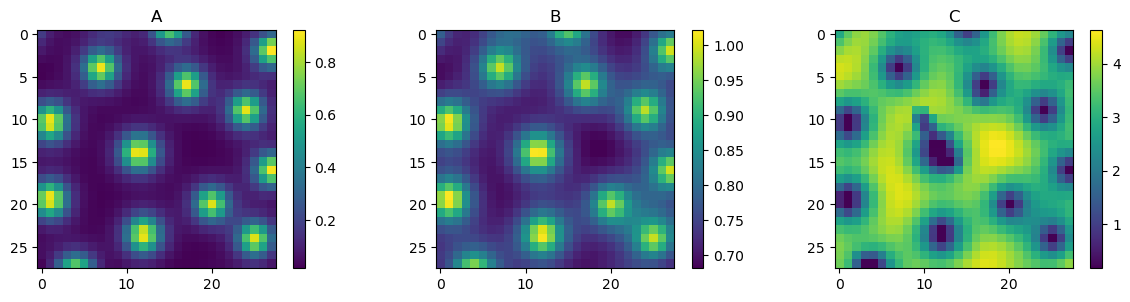

    Early dtoped at 152342
Epoch: 152342 
 data loss:0.020865, 
data A loss:0.011247, data B loss:0.003284, data C loss:0.006334, 
Laplacian A loss:0.012280, Laplacian B loss:0.011837
Physics loss:0.454589
Negative loss:0.000000

 b_A=-0.0640, b_B=-0.0029, b_C=0.3186, V_A=14.0851, V_B=63.1781, V_C=5.1158, mu_A=0.7972, mu_B=3.6086, K_AA=0.8207, K_AB=0.7521, K_AC=3.7191, K_BA=0.7630, K_BC=0.6037, K_CB=19.9868, K_CC=1.6759


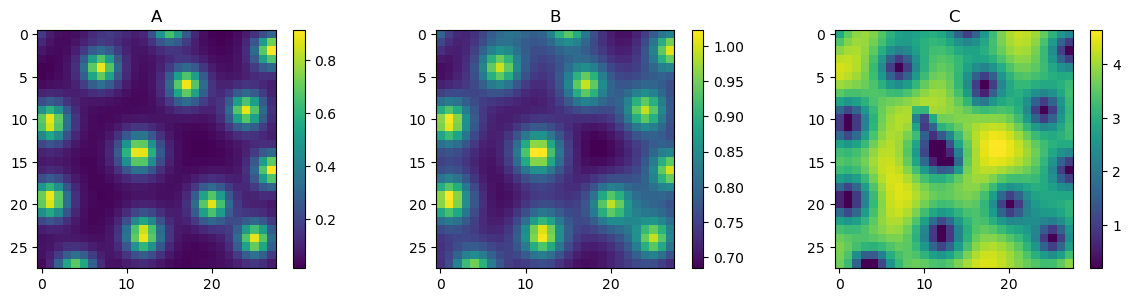

In [6]:
torch.manual_seed(42)
np.random.seed(42)
dtype = torch.float32
torch.set_default_dtype(dtype)

def create_var(init=None):
    if init is None:
        return torch.nn.Parameter(torch.ones(1, requires_grad=True, device=dev_str)), []
    else:
        return torch.nn.Parameter(init*torch.ones(1, requires_grad=True, device=dev_str)), []


D_A=params["D_A"]#, sampled_D_A = create_var()
D_B=params["D_B"]#, sampled_D_B = create_var()
b_A, sampled_b_A = create_var(1)
b_B, sampled_b_B = create_var(1)
b_C, sampled_b_C = create_var(1)
V_A, sampled_V_A = create_var(1)
V_B, sampled_V_B = create_var(1)
V_C, sampled_V_C = create_var(1)
mu_A, sampled_mu_A = create_var(1)
mu_B, sampled_mu_B = create_var(1)
mu_C=params["mu_C"]#, sampled_mu_C = create_var()
K_AA, sampled_K_AA = create_var(K_AA_init)
K_AB, sampled_K_AB = create_var(K_AB_init)
K_AC, sampled_K_AC = create_var(K_AC_init)
K_BA, sampled_K_BA = create_var(K_BA_init)
K_BC, sampled_K_BC = create_var(K_BC_init)
K_CB, sampled_K_CB = create_var(K_CB_init)
K_CC, sampled_K_CC = create_var(K_CC_init)
n = params['n']

params_name_list = [#"D_A", "D_B", 
                    "b_A", "b_B", "b_C", "V_A", "V_B", "V_C", "mu_A", "mu_B", #"mu_C",
                    "K_AA", "K_AB", "K_AC", "K_BA", "K_BC", "K_CB", 
                    "K_CC"
]

params_list = [#D_A, D_B, 
               b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, #mu_C,
               K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, 
               K_CC
]

params_sampled_list =[#sampled_D_A, sampled_D_B,
                      sampled_b_A, sampled_b_B, sampled_b_C, sampled_V_A, sampled_V_B, sampled_V_C,
                      sampled_mu_A, sampled_mu_B, #sampled_mu_C,
                      sampled_K_AA, sampled_K_AB, sampled_K_AC, sampled_K_BA, sampled_K_BC,
                      sampled_K_CB, sampled_K_CC
                     ]

###########################################################
# Inputs
# restrict to inner boundaries
x = torch.linspace(0, run_params.Lx, run_params.Ix)[x_slice].to(device)
y = torch.linspace(0, run_params.Ly, run_params.Jy)[y_slice].to(device)
X,Y = torch.meshgrid(x, y, indexing='ij')
data_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)

def transform(x, l, u):
    return (u-l)*x + l

x2 = transform(torch.rand(run_params.Ix),torch.min(x).item(),torch.max(x).item())
y2 = transform(torch.rand(run_params.Jy),torch.min(y).item(),torch.max(y).item())
X2,Y2 = torch.meshgrid(x2, y2, indexing='ij')
physics_X = torch.vstack([X2.flatten(), Y2.flatten()]).T.requires_grad_(True).to(device)
##########################################################
#   Data
# restrict to inner boundaries
data_A = torch.from_numpy(A_n[x_slice,y_slice].flatten()).to(device)
data_B = torch.from_numpy(B_n[x_slice,y_slice].flatten()).to(device)
data_C = torch.from_numpy(C_n[x_slice,y_slice].flatten()).to(device)
###########################################################
# Laplacians
# First, find the finite-diff Laplacian on the whole domain,
# then, select the inner boundaries. This way, the boundaries 
# effets removed
diffusion_scale_factor = (run_params.Ix-1)*(run_params.Jy-1)/(run_params.Lx*run_params.Ly)
laplacianA = diffusion_scale_factor * grad_diff(A_n)
laplacianB = diffusion_scale_factor * grad_diff(B_n)

laplacianA = torch.tensor(laplacianA[x_slice,y_slice].flatten()).to(device)
laplacianB = torch.tensor(laplacianB[x_slice,y_slice].flatten()).to(device)
###########################################################
zeors_tensor = torch.zeros(data_X.shape[0]).to(device)
###########################################################
# Model
lb = torch.tensor([torch.min(x).item(), torch.min(y).item()]).to(device)
ub = torch.tensor([torch.max(x).item(), torch.max(y).item()]).to(device)
model = Net_sep_dense_normalised(2,3,[256,256,256,256], lb, ub).to(device)
###########################################################
# optimizer
optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr': 1e-4},
                              {'params': params_list, 'lr': .1}]
                              , lr=1e-4)#.LBFGS([*model.parameters(), *params_list], lr=1
                             #,line_search_fn='strong_wolfe')#


epochs = 150000
loss_data = 0.0
lambda_data = 1.0
loss_physics = 0.0
lambda_physics = 1e-4
loss_laplacian_physics = 0.0
lambda_physics_laplacian = 1e-2
loss_negative = 0
lambda_negative = 100

losses = np.zeros((7, epochs+6000))
last_loss = np.inf

def act(x, km, n=2):
    return x**n / (x**n + km**n)

def inh(x, km, n=2):
    return km**n / (x**n + km**n)

for i in range(epochs +6000): 
    # L-BFGS
    def closure():
        
        optimizer.zero_grad()

        #################################
        # data loss
        data_f_hat = model(data_X)
        data_A_hat = data_f_hat[0].squeeze() 
        data_B_hat = data_f_hat[1].squeeze() 
        data_C_hat = data_f_hat[2].squeeze() 
        loss_A_data = torch.mean((data_A - data_A_hat)**2)
        loss_B_data = torch.mean((data_B - data_B_hat)**2)
        loss_C_data = torch.mean((data_C - data_C_hat)**2)
        loss_data = (loss_A_data + loss_B_data + loss_C_data)/3
        #################################
        loss_negative = torch.mean(torch.maximum(-data_A_hat, zeors_tensor)**2
                       )+ torch.mean(torch.maximum(-data_B_hat, zeors_tensor)**2
                       )+ torch.mean(torch.maximum(-data_C_hat, zeors_tensor)**2
                       )
        #################################
        # Laplacians derivatives        
        laplacianA_hat = Laplacian(data_A_hat, data_X)
        laplacianB_hat = Laplacian(data_B_hat, data_X)
        
        A_loss_laplacian = torch.mean((laplacianA_hat-laplacianA)**2)
        B_loss_laplacian = torch.mean((laplacianB_hat-laplacianB)**2)
        loss_laplacian_physics = A_loss_laplacian + B_loss_laplacian
        ###############################
        # physics derivatives  
        physics_f_hat = model(physics_X)
        A = physics_f_hat[0].squeeze() 
        B = physics_f_hat[1].squeeze() 
        C = physics_f_hat[2].squeeze() 
        
        laplacianA_hat = Laplacian(A, physics_X)
        laplacianB_hat = Laplacian(B, physics_X)
        
        F_A =  b_A + V_A*act(A, K_AA, n)*inh(B, K_BA, n) - mu_A * A    
        F_B =  b_B + V_B*act(A, K_AB, n)*inh(C, K_CB, n) - mu_B * B        
        F_C =  b_C + V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n) - mu_C * C        

        dAdt = D_A * laplacianA_hat + F_A
        dBdt = D_B * laplacianB_hat + F_B
        dCdt = F_C
        ################################
        # physics loss
        # Construct the physics loss here
        A_loss_physics = torch.mean(dAdt**2)
        B_loss_physics = torch.mean(dBdt**2)
        C_loss_physics = torch.mean(dCdt**2)
        loss_physics = (A_loss_physics  
                        + B_loss_physics 
                        + C_loss_physics)
        ###############################
        total_loss = (
            +lambda_data*loss_data            
            +lambda_physics_laplacian*loss_laplacian_physics
            +lambda_physics*loss_physics
            #+lambda_negative*loss_negative
                        )

        total_loss.backward(retain_graph=True)
        
        
        losses[:,i] = (loss_A_data.item(), loss_B_data.item(), loss_C_data.item(), 
                       A_loss_laplacian.item(), B_loss_laplacian.item(),
                       loss_physics.item(), loss_negative.item())                    
            
        return total_loss
    
    
    
    optimizer.step(closure)
    
    def show_outputs(i):
        ls = np.sqrt(losses[:, i])
        print("============================================")
        print(f"Epoch: {i+1} \n data loss:{np.sum(ls[0:3]):.6f}, \n"
              f"data A loss:{ls[0]:.6f}, data B loss:{ls[1]:.6f}, data C loss:{ls[2]:.6f}, \n"
              f"Laplacian A loss:{ls[3]:.6f}, Laplacian B loss:{ls[4]:.6f}\n"
              f"Physics loss:{ls[5]:.6f}\n"
              f"Negative loss:{ls[6]:.6f}\n"
              f"\n"
              ,
              ", ".join([f"{name}={param.item():.4f}" for param, name in zip(params_list, params_name_list)])
             )
        data_f_hat = model(data_X)        
        data_A_hat = data_f_hat[0].squeeze() 
        data_B_hat = data_f_hat[1].squeeze() 
        data_C_hat = data_f_hat[2].squeeze() 
        plot_n_im([to(data_A_hat.cpu().detach().numpy()), 
                   to(data_B_hat.cpu().detach().numpy()), 
                   to(data_C_hat.cpu().detach().numpy())], 
           ["A","B","C"],          
        figsize=(12, 3)); plt.tight_layout();plt.show()
       
    
    if i < epochs and last_loss > np.sum(losses[:,i]):
        last_loss =  np.sum(losses[:,i])
            
    elif np.sum(losses[:,i]) < last_loss:
        print("============================================")
        print(f"    Early dtoped at {i+1}")
        print("============================================")
        show_outputs(i)
        early_stop = True
        with torch.no_grad():
            for i,(param, name) in enumerate(zip(params_list, params_name_list)):
                l,u = get_bound(name)
                param[:] = param.clamp(l,u)
                params_sampled_list[i].append(param.item())
        break        
    
    if (i+1)%10000 == 0 or i==0:        
        show_outputs(i)
        
    with torch.no_grad():
        for i,(param, name) in enumerate(zip(params_list, params_name_list)):
            l,u = get_bound(name)
            param[:] = param.clamp(l,u)
            params_sampled_list[i].append(param.item())
            


# Plot the trained outputs

A RMSE:0.011173996425187595 B RMSE:0.0032489201127290927 C RMSE:0.0062881258008870835
F_A actual:0.07876369995168694, F_A:0.06471733748912811, RMSE: 0.032615830361579445
F_B actual:50.083868132096576, F_B:39.38430404663086, RMSE: 0.9185109997096781
F_C actual:0.005210661247615525, F_C:0.005105070769786835, RMSE: 0.014068581633795213

Laplacian A RMSE: 0.013628585547115801
Laplacian B RMSE: 0.011957373403266322

dAdt RMSE: 0.03265333277125895
dBdt RMSE: 0.9189669124759545
dCdt RMSE: 0.014068581633795213


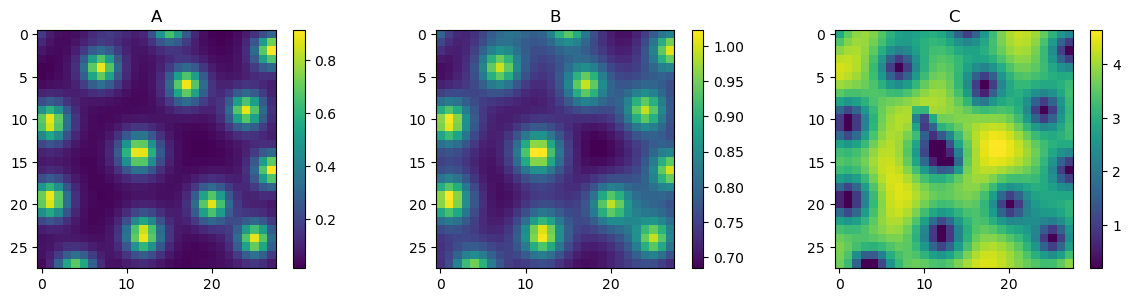

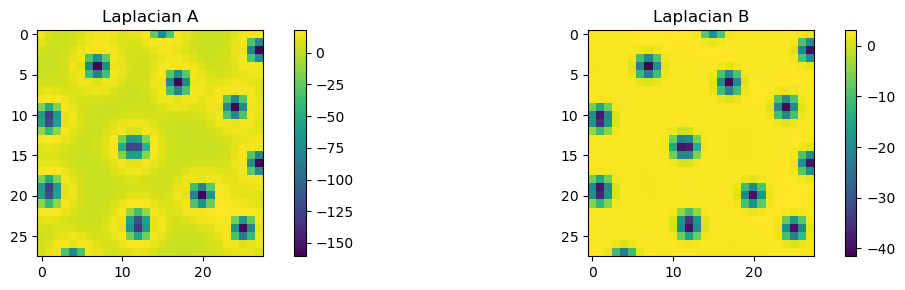

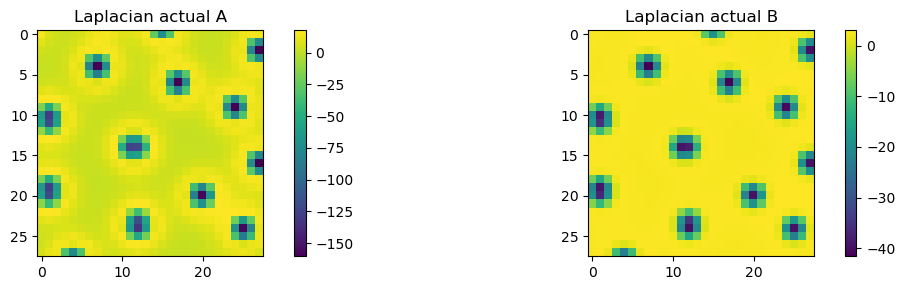

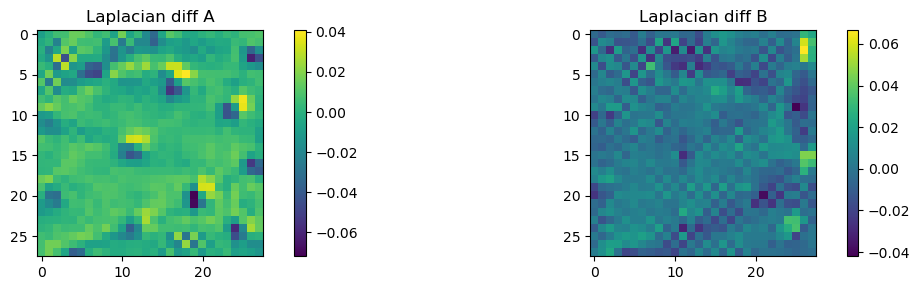

In [7]:
physics_f = model(data_X)
A_hat = physics_f[0].squeeze()
B_hat = physics_f[1].squeeze()
C_hat = physics_f[2].squeeze()

laplacianA_hat = Laplacian(A_hat, data_X)
laplacianB_hat = Laplacian(B_hat, data_X)

A_hat = to(A_hat.cpu().detach().numpy())
B_hat = to(B_hat.cpu().detach().numpy())
C_hat = to(C_hat.cpu().detach().numpy())
laplacianA_hat = to(laplacianA_hat.cpu().detach().numpy())
laplacianB_hat = to(laplacianB_hat.cpu().detach().numpy())


laplacianA = diffusion_scale_factor * grad_diff(A_n)[x_slice,y_slice]
laplacianB = diffusion_scale_factor * grad_diff(B_n)[x_slice,y_slice]

n = params["n"]

A = A_n[x_slice,y_slice]
B = B_n[x_slice,y_slice]
C = C_n[x_slice,y_slice]

F_A =  params["b_A"] + params["V_A"]*act(A, params["K_AA"], n)*inh(B, params["K_BA"], n) - params["mu_A"] * A
F_A_hat =  params["b_A"] + params["V_A"]*act(A_hat, params["K_AA"], n)*inh(B_hat, params["K_BA"], n) - params["mu_A"] * A_hat
F_B =  params["b_B"] + params["V_B"]*act(A, params["K_AB"], n)*inh(C, params["K_CB"], n) - params["mu_B"] * B
F_B_hat =  params["b_B"] + params["V_B"]*act(A_hat, params["K_AB"], n)*inh(C_hat, params["K_CB"], n) - params["mu_B"] * B_hat
F_C =  params["b_C"] + params["V_C"]*inh(A, params["K_AC"], n)*inh(B, params["K_BC"], n)*act(C, params["K_CC"], n) - params["mu_C"] * C
F_C_hat =  params["b_C"] + params["V_C"]*inh(A_hat, params["K_AC"], n)*inh(B_hat, params["K_BC"], n)*act(C_hat, params["K_CC"], n) - params["mu_C"] * C_hat


dAdt = params["D_A"]*laplacianA + F_A
dAdt_hat = params["D_A"]*laplacianA_hat + F_A_hat
dBdt = params["D_B"]*laplacianB + F_B
dBdt_hat = params["D_B"]*laplacianB_hat + F_B_hat

print(f"A RMSE:{np.sqrt(np.mean((A_hat-A)**2))}",
      f"B RMSE:{np.sqrt(np.mean((B_hat-B)**2))}",
      f"C RMSE:{np.sqrt(np.mean((C_hat-C)**2))}")

print(f"F_A actual:{np.mean(F_A**2)}, F_A:{np.mean(F_A_hat**2)}, RMSE: {np.sqrt(np.mean((F_A - F_A_hat)**2))}")
print(f"F_B actual:{np.mean(F_B**2)}, F_B:{np.mean(F_B_hat**2)}, RMSE: {np.sqrt(np.mean((F_B - F_B_hat)**2))}")
print(f"F_C actual:{np.mean(F_C**2)}, F_C:{np.mean(F_C_hat**2)}, RMSE: {np.sqrt(np.mean((F_C - F_C_hat)**2))}")
      

print()
print(f"Laplacian A RMSE: {np.sqrt(np.mean((laplacianA_hat-laplacianA)**2))}")
print(f"Laplacian B RMSE: {np.sqrt(np.mean((laplacianB_hat-laplacianB)**2))}")

print()
print(f"dAdt RMSE: {np.sqrt(np.mean((dAdt-dAdt_hat)**2))}")
print(f"dBdt RMSE: {np.sqrt(np.mean((dBdt-dBdt_hat)**2))}")
print(f"dCdt RMSE: {np.sqrt(np.mean((F_C-F_C_hat)**2))}")

plot_n_im([A_hat, B_hat, C_hat], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()


plot_n_im([laplacianA_hat, laplacianB_hat], 
          ["Laplacian A", "Laplacian B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([laplacianA, laplacianB], 
          ["Laplacian actual A", "Laplacian actual B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([laplacianA_hat-laplacianA, laplacianB_hat-laplacianB], 
          ["Laplacian diff A", "Laplacian diff B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()



# Plot losses

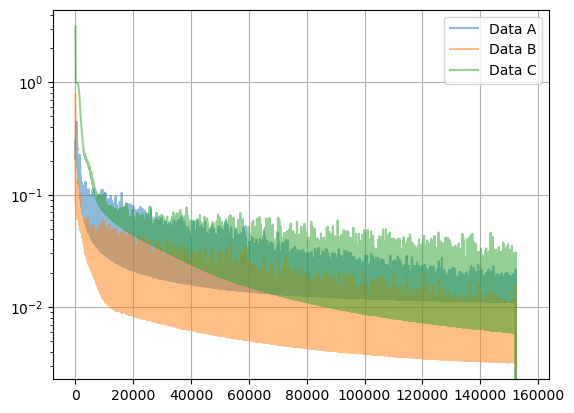

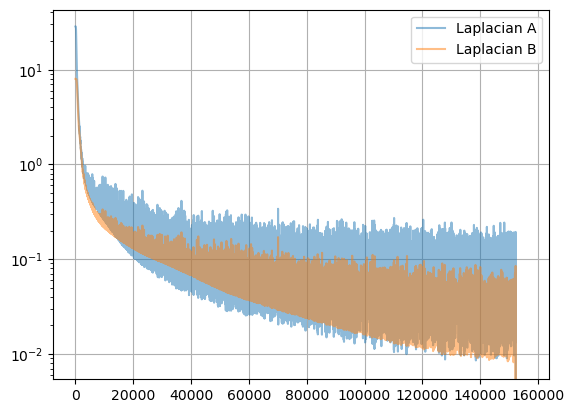

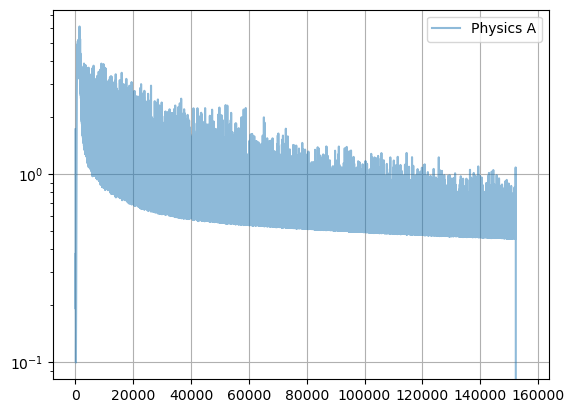

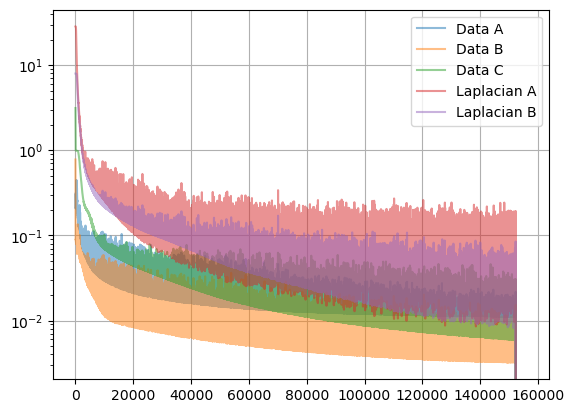

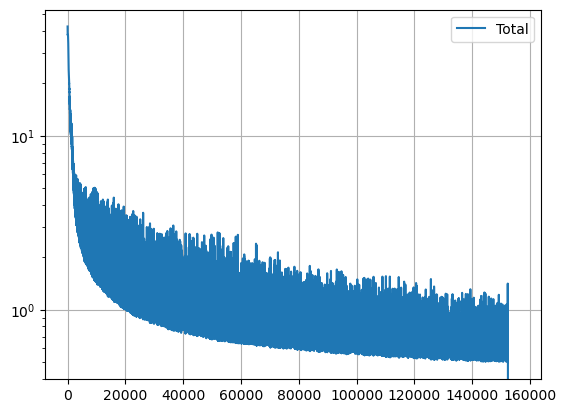

In [8]:
ls= np.sqrt(losses)
plt.plot(ls[0,:], alpha=.5, label="Data A")
plt.plot(ls[1,:], alpha=.5, label="Data B")
plt.plot(ls[2,:], alpha=.5, label="Data C")
plt.yscale('log');plt.grid();plt.legend();plt.show()

plt.plot(ls[3,:], alpha=.5, label="Laplacian A")
plt.plot(ls[4,:], alpha=.5, label="Laplacian B")
plt.yscale('log');plt.grid();plt.legend();plt.show()

plt.plot(ls[5,:], alpha=.5, label="Physics A")
plt.yscale('log');plt.grid();plt.legend();plt.show()


plt.plot(ls[0,:], alpha=.5, label="Data A")
plt.plot(ls[1,:], alpha=.5, label="Data B")
plt.plot(ls[2,:], alpha=.5, label="Data C")
plt.plot(ls[3,:], alpha=.5, label="Laplacian A")
plt.plot(ls[4,:], alpha=.5, label="Laplacian B")
plt.yscale('log'); plt.grid();plt.legend();plt.show()

plt.plot(np.sum(ls, axis=0), label="Total")
plt.yscale('log'); plt.grid();plt.legend();plt.show()


# Plot the trained Field and its difference

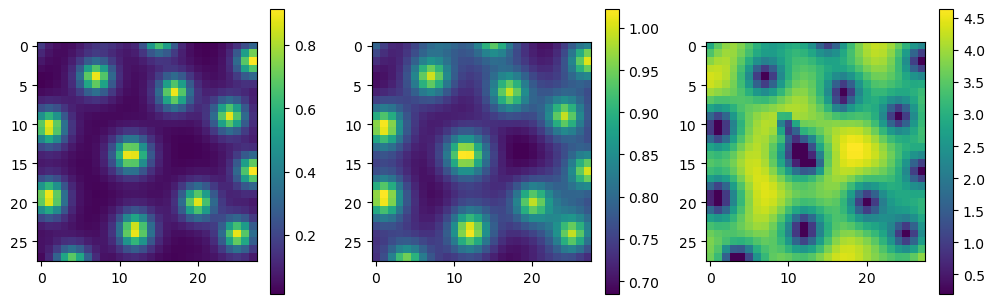

In [9]:
solution_hat = model(data_X)
A_hat = to(solution_hat[0].cpu().detach().numpy())
B_hat = to(solution_hat[1].cpu().detach().numpy())
C_hat = to(solution_hat[2].cpu().detach().numpy())
_ = plt.figure(figsize=(10,6))
plt.subplot(131)
plt.imshow(A_hat)
plt.colorbar(shrink=.5)
plt.subplot(132)
plt.imshow(B_hat)
plt.colorbar(shrink=.5)
plt.subplot(133)
plt.imshow(C_hat)
plt.colorbar(shrink=.5)
plt.tight_layout()
plt.show()

0.011173996425187595
0.0032489201127290927
0.0062881258008870835


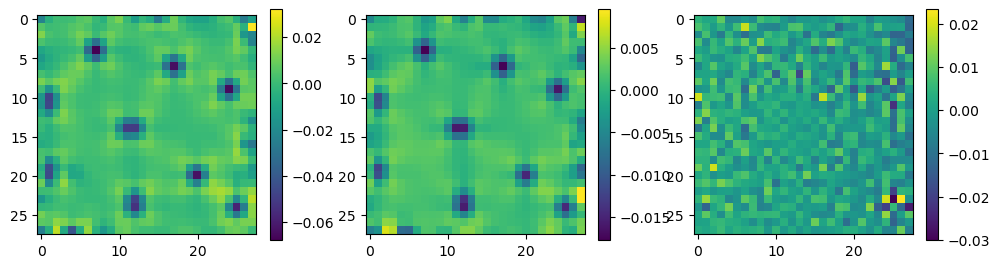

In [10]:
_ = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(A_hat-A)
print(np.sqrt(np.mean((A_hat-A)**2)))
plt.colorbar(shrink=.75)
plt.subplot(132)
plt.imshow(B_hat-B)
print(np.sqrt(np.mean((B_hat-B)**2)))
plt.colorbar(shrink=.75)
plt.subplot(133)
plt.imshow(C_hat-C)
print(np.sqrt(np.mean((C_hat-C)**2)))
plt.colorbar(shrink=.75)
plt.show()


# Second optimisation
## Find the parameters

In [17]:
estimated_params = dict()
for l, name in zip(params_list, params_name_list):    
    estimated_params[name] = l.item()

In [12]:
Ks_bounds = {"K_AA":K_AA_bound, 
             "K_AB":K_AB_bound, 
             "K_AC":K_AC_bound,
             "K_BA":K_BA_bound, 
             "K_BC":K_BC_bound,
             "K_CB":K_CB_bound, 
             "K_CC": K_CC_bound}
def closest_bound(name, v):
    if not name.startswith("K"):
        return np.nan
    lower, upper = Ks_bounds[name]
    if np.abs(v-lower) < np.abs(v-upper):
        return lower
    else:
        return upper 
def get_bound(name):
    if not name.startswith("K"):
        return (np.nan,np.nan)
    return Ks_bounds[name]
print("name \tOriginl \tEst. \tClosest Bound \tBounds")
print("-------------------------------------------------------------------------------------------------------------")
print("\n".join([ f"{name}:\t{params[name]:.3f}\t\t"                                  
                  f"{estimated_params[name]:.3f}\t\t"
                  f"{closest_bound(name, estimated_params[name]):.3f}\t\t"
                  f"({get_bound(name)[0]:.3f},{get_bound(name)[1]:.3f})"
      for name in params_name_list
]))

name 	Originl 	Est. 	Closest Bound 	Bounds
-------------------------------------------------------------------------------------------------------------
b_A:	0.001		0.000		nan		(nan,nan)
b_B:	1.000		0.000		nan		(nan,nan)
b_C:	0.100		0.319		nan		(nan,nan)
V_A:	100.000		14.085		nan		(nan,nan)
V_B:	100.000		63.178		nan		(nan,nan)
V_C:	10.000		5.116		nan		(nan,nan)
mu_A:	1.000		0.797		nan		(nan,nan)
mu_B:	5.000		3.609		nan		(nan,nan)
K_AA:	1.000		0.821		0.003		(0.003,3.717)
K_AB:	1.000		0.752		0.003		(0.003,3.717)
K_AC:	1.000		3.717		3.717		(0.003,3.717)
K_BA:	0.500		0.763		0.174		(0.174,3.935)
K_BC:	0.500		0.604		0.174		(0.174,3.935)
K_CB:	25.000		19.979		19.979		(0.053,19.979)
K_CC:	1.000		1.676		0.053		(0.053,19.979)


In [12]:
Ks_bounds = {"K_AA":K_AA_bound, 
             "K_AB":K_AB_bound, 
             "K_AC":K_AC_bound,
             "K_BA":K_BA_bound, 
             "K_BC":K_BC_bound,
             "K_CB":K_CB_bound, 
             "K_CC": K_CC_bound}
def closest_bound(name, v):
    if not name.startswith("K"):
        return np.nan
    lower, upper = Ks_bounds[name]
    if np.abs(v-lower) < np.abs(v-upper):
        return lower
    else:
        return upper 
def get_bound(name):
    if not name.startswith("K"):
        return (np.nan,np.nan)
    return Ks_bounds[name]
print("name \tOriginl \tEst. \tClosest Bound \tBounds")
print("-------------------------------------------------------------------------------------------------------------")
print("\n".join([ f"{name}:\t{params[name]:.3f}\t\t"                                  
                  f"{estimated_params[name]:.3f}\t\t"
                  f"{closest_bound(name, estimated_params[name]):.3f}\t\t"
                  f"({get_bound(name)[0]:.3f},{get_bound(name)[1]:.3f})"
      for name in params_name_list
]))

name 	Originl 	Est. 	Closest Bound 	Bounds
-------------------------------------------------------------------------------------------------------------
b_A:	0.001		0.000		nan		(nan,nan)
b_B:	1.000		0.000		nan		(nan,nan)
b_C:	0.100		0.371		nan		(nan,nan)
V_A:	100.000		2.840		nan		(nan,nan)
V_B:	100.000		62.344		nan		(nan,nan)
V_C:	10.000		3.701		nan		(nan,nan)
mu_A:	1.000		0.789		nan		(nan,nan)
mu_B:	5.000		3.607		nan		(nan,nan)
K_AA:	1.000		0.692		0.003		(0.003,3.717)
K_AB:	1.000		0.747		0.003		(0.003,3.717)
K_AC:	1.000		3.717		3.717		(0.003,3.717)
K_BA:	0.500		2.518		3.935		(0.174,3.935)
K_BC:	0.500		0.686		0.174		(0.174,3.935)
K_CB:	25.000		19.979		19.979		(0.053,19.979)
K_CC:	1.000		1.906		0.053		(0.053,19.979)


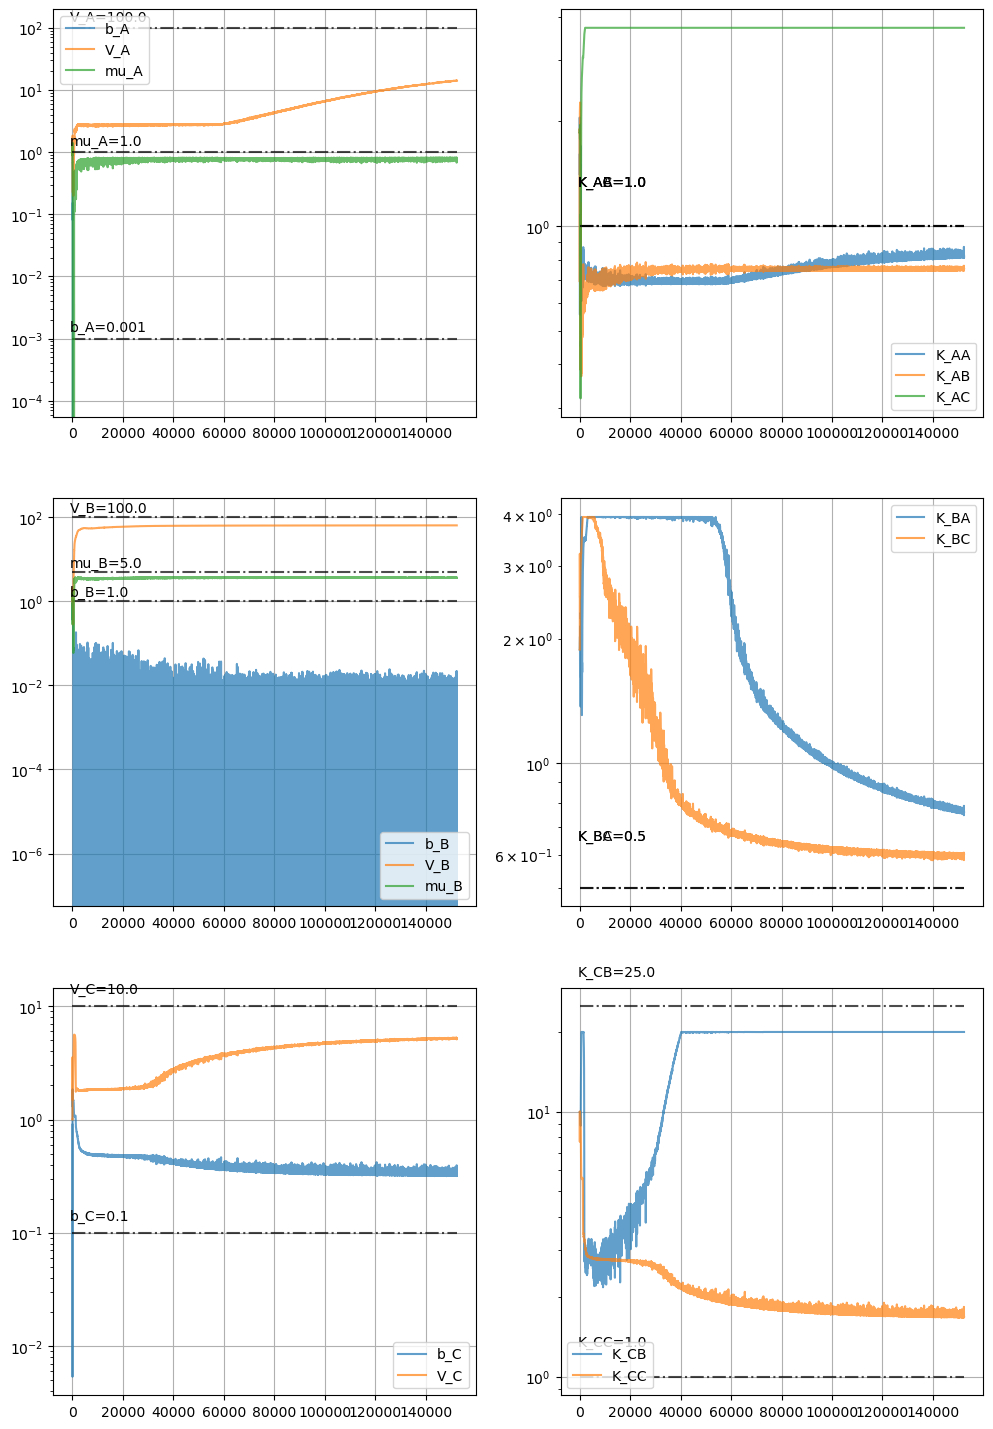

In [13]:
def plot_params(ax, names):    
    for i,(param, name) in enumerate(zip(params_list, params_name_list)):    
        if name not in names:
            continue
        ax.plot(params_sampled_list[i], label=f"{name}", alpha=.7)
        ax.hlines(params[name], 0, len(params_sampled_list[i]), 
                   linestyles='-.', alpha=.7, color='black')
        ax.text(-1000, 1.3*params[name], f"{name}={params[name]}")
    plt.yscale('log');plt.legend();plt.grid()   
    
_ = plt.figure(figsize=(12,18))
plot_params(plt.subplot(321), ["b_A", "mu_A", "V_A"])
plot_params(plt.subplot(322), ["K_AA","K_AB","K_AC"])
plot_params(plt.subplot(323), ["b_B", "mu_B", "V_B"])
plot_params(plt.subplot(324), ["K_BA","K_BC"])
plot_params(plt.subplot(325), ["b_C", "mu_C", "V_C"])
plot_params(plt.subplot(326), ["K_CB","K_CC"])

In [14]:
import pickle

torch.save(model, "./06_outputs/model_PINN_31")
torch.save(model.state_dict(), "./06_outputs/model_PINN_state_31")
with open('./06_outputs/model_PINN_params_name_list_31.npy', 'wb') as f:
    np.save(f, params_name_list)    
with open('./06_outputs/model_PINN_losses_31.npy', 'wb') as f:
    np.save(f, losses)    
with open(f"./06_outputs/model_PINN_estimated_params_31.pkl", "wb") as f:
    pickle.dump((dict(params),  dict(estimated_params)), f) 
with open(f"./06_outputs/model_PINN_estimated_params_list_31.pkl", "wb") as f:
    pickle.dump(params_sampled_list, f)     

In [19]:
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/pytorch")

sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")

from turing.three_nodes_circuits import create_circuit_3954
from pde_solvers.cn import RD_2D_1st_Order, Neumann_Boundary_2D

D_A, D_B , n, mu_C= 0.01, 1.0, 4, params["mu_C"]
model_integrator = RD_2D_1st_Order(Ds=[D_A, D_B, 0], 
                        delta_t=100/10000, 
                        Lx=10, Ly=10, 
                        Ix=128, Jy=128,
                        boundary_condition=Neumann_Boundary_2D)

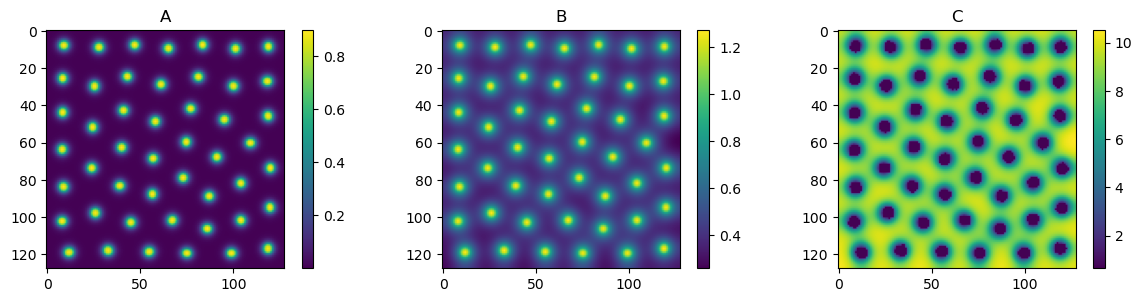

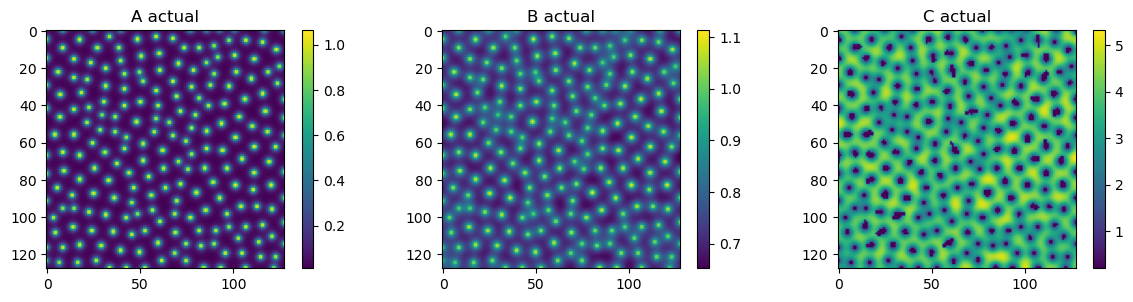

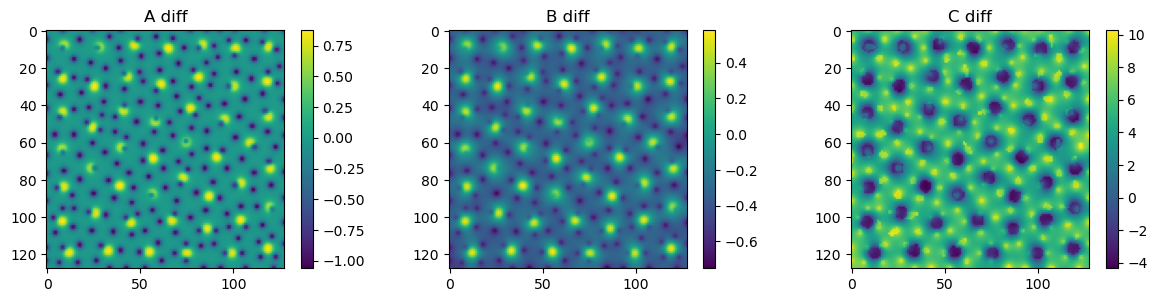

In [21]:

params2 = {}
for k,v in estimated_params.items():
    if not k.startswith("K"):
        params2[k] = v
    else:
        lower, upper = Ks_bounds[k]
        if v < lower:
            params2[k] = lower
        elif v > upper:
            params2[k] = upper
        else:
            params2[k] = v

kinetics = create_circuit_3954(n,params2["b_A"], params2["mu_A"], params2["V_A"], 
                                       params2["K_AA"], params2["K_AB"], params2["K_AC"],
                                       params2["b_B"], params2["mu_B"], params2["V_B"], 
                                       params2["K_BA"], params2["K_BC"],
                                       params2["b_C"], mu_C, params2["V_C"], 
                                       params2["K_CB"], params2["K_CC"])

(A_init, B_init, C_init) = (solution[0, 0, :, :].flatten(),
                            solution[0, 1, :, :].flatten(),
                            solution[0, 2, :, :].flatten())
solution_test = model_integrator.integrate([A_init, B_init, C_init],kinetics, 40*10000, record_steps=10000)

A_test = solution_test[-1,0, :].reshape((128,128))
B_test = solution_test[-1,1, :].reshape((128,128))
C_test = solution_test[-1,2, :].reshape((128,128))
plot_n_im([A_test,B_test,C_test], 
           ["A","B","C"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

plot_n_im([solution[105, 0, :, :],solution[105, 1, :, :],solution[105, 2, :, :]], 
           ["A actual","B actual","C actual"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

plot_n_im([A_test-solution[105, 0, :, :],
           B_test-solution[105, 1, :, :],
           C_test-solution[105, 2, :, :]], 
           ["A diff","B diff","C diff"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

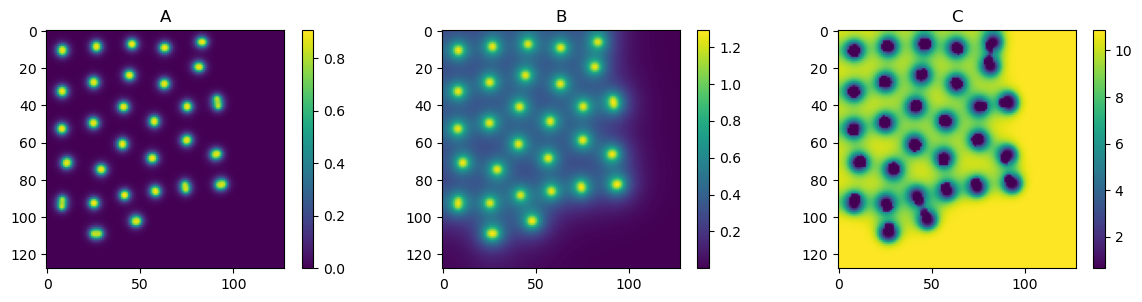

In [27]:
A_test = solution_test[4,0, :].reshape((128,128))
B_test = solution_test[4,1, :].reshape((128,128))
C_test = solution_test[4,2, :].reshape((128,128))
plot_n_im([A_test,B_test,C_test], 
           ["A","B","C"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 


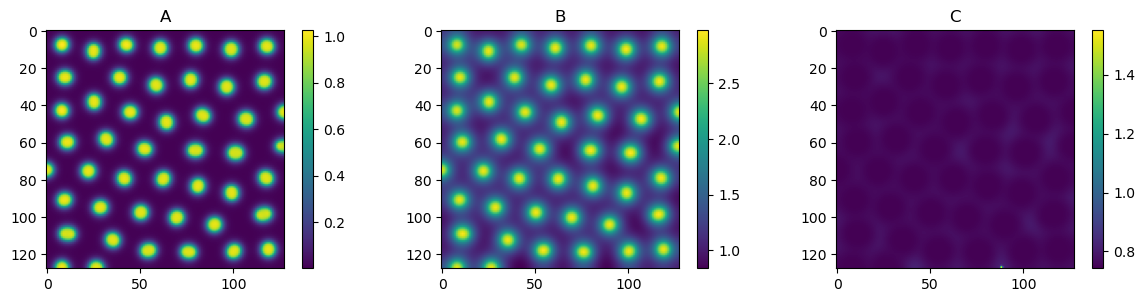

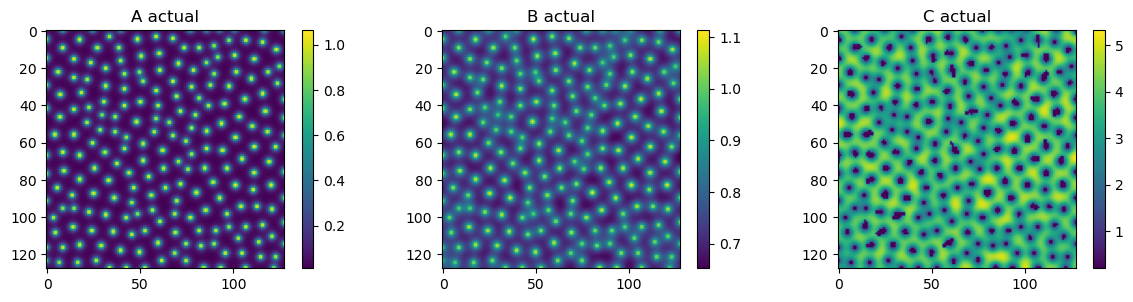

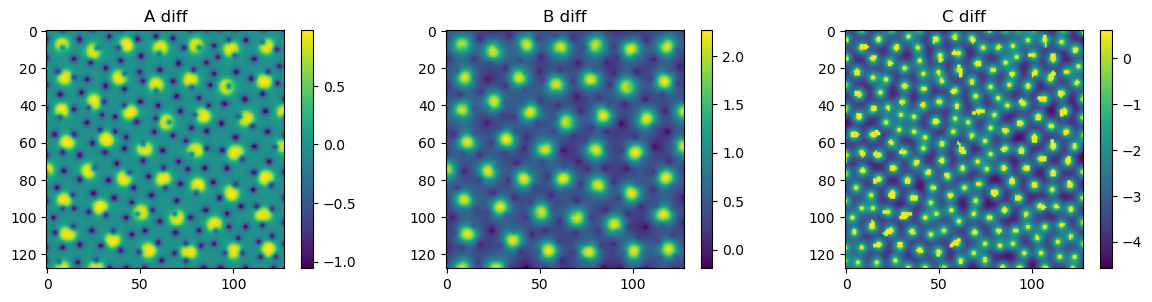

In [15]:

params2 = {}
for k,v in estimated_params.items():
    if not k.startswith("K"):
        params2[k] = v
    else:
        lower, upper = Ks_bounds[k]
        if v < lower:
            params2[k] = lower
        elif v > upper:
            params2[k] = upper
        else:
            params2[k] = v

kinetics = create_circuit_3954(n,params2["b_A"], params2["mu_A"], params2["V_A"], 
                                       params2["K_AA"], params2["K_AB"], params2["K_AC"],
                                       params2["b_B"], params2["mu_B"], params2["V_B"], 
                                       params2["K_BA"], params2["K_BC"],
                                       params2["b_C"], mu_C, params2["V_C"], 
                                       params2["K_CB"], params2["K_CC"])

(A_init, B_init, C_init) = (solution[0, 0, :, :].flatten(),
                            solution[0, 1, :, :].flatten(),
                            solution[0, 2, :, :].flatten())
solution_test = model_integrator.integrate([A_init, B_init, C_init],kinetics, 4*5000, record_steps=5000)

A_test = solution_test[-1,0, :].reshape((128,128))
B_test = solution_test[-1,1, :].reshape((128,128))
C_test = solution_test[-1,2, :].reshape((128,128))
plot_n_im([A_test,B_test,C_test], 
           ["A","B","C"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

plot_n_im([solution[105, 0, :, :],solution[105, 1, :, :],solution[105, 2, :, :]], 
           ["A actual","B actual","C actual"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

plot_n_im([A_test-solution[105, 0, :, :],
           B_test-solution[105, 1, :, :],
           C_test-solution[105, 2, :, :]], 
           ["A diff","B diff","C diff"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

In [16]:
{1:31,
2:3,
3:9, 
4:25,
5:14,
6:60,
7:24,
8:26,
9:65}

{1: 31, 2: 3, 3: 9, 4: 25, 5: 14, 6: 60, 7: 24, 8: 26, 9: 65}